In [2]:
# Please use Python 3.10 or 3.11 for PyTorch compatibility.
# PyTorch does NOT support Python 3.12 as of now.
# If you are using Python 3.12, you must create a new environment with Python 3.10 or 3.11 and reinstall the packages.

# ==========================
# FIX FOR OSError: [WinError 126] ...fbgemm.dll
# ==========================
# 1. Download and install Python 3.10 or 3.11 from https://www.python.org/downloads/
# 2. Open your terminal (Command Prompt or PowerShell)
# 3. Create a new virtual environment:
#    python3.10 -m venv .venv
# 4. Activate the environment:
#    .venv\Scripts\activate  # On Windows
# 5. Check Python version:
#    python --version  # Should show 3.10 or 3.11
# 6. Install required packages:
#    pip install torch torchvision torchaudio matplotlib tqdm transformers
# 7. Restart Jupyter Notebook in this environment.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True


In [4]:
# Define the learning rate for the optimizer
learning_rate = 1e-4

# Image size for processing
image_size = 128

# Define the number of epochs for training
nepochs = 200

# Define the batch size for mini-batch gradient descent
batch_size = 128

# Dataset configuration for VQA-RAD
# We're using the VQA-RAD dataset instead of COCO Captions
# VQA-RAD is a dataset for Visual Question Answering in Radiology
from datasets import load_dataset

# Load the VQA-RAD dataset
ds = load_dataset("flaviagiammarino/vqa-rad")

# Define the root directory for saving processed data
data_set_root = os.path.join(os.getcwd(), 'datasets')

# Create datasets directory if it doesn't exist
os.makedirs(data_set_root, exist_ok=True)

# Define train and validation paths
train_set = 'train'
validation_set = 'validation'

# Set up paths for training data
train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = os.path.join(data_set_root, f'annotations_{train_set}.json')

# Set up paths for validation data
val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = os.path.join(data_set_root, f'annotations_{validation_set}.json')

README.md:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

(…)-00000-of-00001-eb8844602202be60.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

(…)-00000-of-00001-e5bc3d208bb4deeb.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [1]:
from datasets import load_dataset

# Load the VQA-RAD dataset
ds = load_dataset("flaviagiammarino/vqa-rad")

In [5]:
# Simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

In [27]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomErasing(p=0.5)
])

# Define image transformations for validation
val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Custom Dataset class for VQA-RAD
class VQARADDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        question = item['question']
        answer = item['answer']
        
        if self.transform:
            image = self.transform(image)
        
        return image, (question, answer)

# Create train and validation datasets
train_dataset = VQARADDataset(
    ds['train'],
    transform=train_transform
)

val_dataset = VQARADDataset(
    ds['test'],
    transform=val_transform
)

# Create data loaders
data_loader_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)

data_loader_val = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)

In [29]:
def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

    
# Define an Vision Encoder module for the Transformer architecture
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, 
                                                      hidden_size).normal_(std=0.02))
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=False, masking=False) for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)
        
        return embs
    
    
# Define an Vision Encoder-Decoder module for the Transformer architecture
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        # Create an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)
        
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

In [30]:
# Add Text Encoder for questions
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=3, num_heads=4):
        super(TextEncoder, self).__init__()
        
        # Text embedding layer
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Transformer blocks for processing text
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                           decoder=False, masking=False) 
            for _ in range(num_layers)
        ])
    
    def forward(self, text_tokens, attention_mask=None):
        bs, seq_len = text_tokens.shape
        
        # Get embeddings
        x = self.embedding(text_tokens)
        
        # Add positional embeddings
        seq_idx = torch.arange(seq_len, device=x.device)
        pos_emb = self.pos_emb(seq_idx).reshape(1, seq_len, -1).expand(bs, -1, -1)
        x = x + pos_emb
        
        # Process through transformer blocks
        for block in self.blocks:
            x = block(x, input_key_mask=attention_mask)
            
        return x

# Modify VQA model
class VQAModel(nn.Module):
    def __init__(self, image_size, channels_in, vocab_size, num_answers, 
                 patch_size=16, hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VQAModel, self).__init__()
        
        # Vision encoder
        self.vision_encoder = VisionEncoder(
            image_size=image_size,
            channels_in=channels_in,
            patch_size=patch_size,
            hidden_size=hidden_size,
            num_layers=num_layers[0],
            num_heads=num_heads
        )
        
        # Question encoder
        self.question_encoder = TextEncoder(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers[0],
            num_heads=num_heads
        )
        
        # Fusion and answer prediction
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.classifier = nn.Linear(hidden_size, num_answers)
        
    def forward(self, images, questions, question_mask=None):
        # Encode images [B, L, H]
        vision_features = self.vision_encoder(images)
        vision_pooled = vision_features.mean(dim=1)  # [B, H]
        
        # Encode questions [B, L, H]
        question_features = self.question_encoder(questions, question_mask)
        question_pooled = question_features.mean(dim=1)  # [B, H]
        
        # Combine features
        combined = torch.cat([vision_pooled, question_pooled], dim=1)
        fused = self.fusion(combined)
        
        # Predict answer
        logits = self.classifier(fused)
        return logits

# Add vocabulary and tokenizer for questions and answers
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.num_words = 2
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.num_words
            self.idx2word[self.num_words] = word
            self.num_words += 1
    
    def __len__(self):
        return self.num_words

# Build vocabularies from the dataset
def build_vocabularies(dataset):
    question_vocab = Vocabulary()
    answer_vocab = Vocabulary()
    
    for item in dataset:
        # Add words from questions
        for word in item['question'].split():
            question_vocab.add_word(word.lower())
        # Add answer
        answer_vocab.add_word(item['answer'].lower())
    
    return question_vocab, answer_vocab

# Tokenizer function
def tokenize_text(text, vocab, max_length=64):
    tokens = [vocab.word2idx.get(word.lower(), vocab.word2idx['<unk>']) 
             for word in text.split()]
    # Pad sequence
    tokens = tokens[:max_length] + [vocab.word2idx['<pad>']] * (max_length - len(tokens))
    return torch.tensor(tokens)

# Modified dataset class
# Modified dataset class with pickle support
class VQARADDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, question_vocab=None, answer_vocab=None):
        self.dataset = list(dataset)  # Convert to list to make it picklable
        self.transform = transform
        self.question_vocab = question_vocab
        self.answer_vocab = answer_vocab

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        question = tokenize_text(item['question'], self.question_vocab)
        answer = self.answer_vocab.word2idx[item['answer'].lower()]
        
        if self.transform:
            image = self.transform(image)
        
        return image, question, answer
    
    def __getstate__(self):
        # Custom getstate to handle pickling
        state = self.__dict__.copy()
        return state

    def __setstate__(self, state):
        # Custom setstate to handle unpickling
        self.__dict__.update(state)

In [31]:
question_vocab, answer_vocab = build_vocabularies(ds['train'])

In [32]:
# Create datasets
train_dataset = VQARADDataset(
    ds['train'],
    transform=train_transform,
    question_vocab=question_vocab,
    answer_vocab=answer_vocab
)

val_dataset = VQARADDataset(
    ds['test'],
    transform=val_transform,
    question_vocab=question_vocab,
    answer_vocab=answer_vocab
)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQAModel(
    image_size=image_size,
    channels_in=3,
    vocab_size=len(question_vocab),
    num_answers=len(answer_vocab),
    hidden_size=128,
    num_layers=(3, 3),
    num_heads=4
).to(device)

In [34]:
class VQARADDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, question_vocab=None, answer_vocab=None):
        self.dataset = list(dataset)
        self.transform = transform
        self.question_vocab = question_vocab
        self.answer_vocab = answer_vocab

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        question = tokenize_text(item['question'], self.question_vocab)
        answer = self.answer_vocab.word2idx[item['answer'].lower()]
        
        if self.transform:
            image = self.transform(image)
        
        # Return three separate values instead of a tuple
        return image, question, answer

In [37]:
# Modified build_vocabularies function to handle out-of-vocabulary answers
def build_vocabularies(dataset):
    question_vocab = Vocabulary()
    answer_vocab = Vocabulary()
    
    # First pass: collect all possible answers from both train and test sets
    for split in ['train', 'test']:
        for item in dataset[split]:
            # Add words from questions
            if split == 'train':  # Only build question vocab from training set
                for word in item['question'].split():
                    question_vocab.add_word(word.lower())
            # Add answer from both train and test sets
            answer_vocab.add_word(item['answer'].lower())
    
    return question_vocab, answer_vocab

# Modified dataset class with better error handling
class VQARADDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, question_vocab=None, answer_vocab=None):
        self.dataset = list(dataset)
        self.transform = transform
        self.question_vocab = question_vocab
        self.answer_vocab = answer_vocab

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        
        # Process question
        question = tokenize_text(item['question'], self.question_vocab)
        
        # Process answer with error handling
        answer_text = item['answer'].lower()
        if answer_text not in self.answer_vocab.word2idx:
            print(f"Warning: answer '{answer_text}' not in vocabulary")
            answer = self.answer_vocab.word2idx['<unk>']
        else:
            answer = self.answer_vocab.word2idx[answer_text]
        
        if self.transform:
            image = self.transform(image)
        
        return image, question, answer

# Rebuild vocabularies using both train and test sets for answers
question_vocab, answer_vocab = build_vocabularies(ds)

# Recreate datasets
train_dataset = VQARADDataset(
    ds['train'],
    transform=train_transform,
    question_vocab=question_vocab,
    answer_vocab=answer_vocab
)

val_dataset = VQARADDataset(
    ds['test'],
    transform=val_transform,
    question_vocab=question_vocab,
    answer_vocab=answer_vocab
)

# Recreate data loaders
data_loader_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)

data_loader_val = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)

# Update model with new vocabulary sizes
model = VQAModel(
    image_size=image_size,
    channels_in=3,
    vocab_size=len(question_vocab),
    num_answers=len(answer_vocab),
    hidden_size=128,
    num_layers=(3, 3),
    num_heads=4
).to(device)

In [38]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training utilities
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for images, questions, answers in progress_bar:
        # Move data to device
        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)
        
        # Forward pass
        outputs = model(images, questions)
        loss = criterion(outputs, answers)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += answers.size(0)
        correct += predicted.eq(answers).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{total_loss/len(progress_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(dataloader), correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for images, questions, answers in progress_bar:
            # Move data to device
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)
            
            # Forward pass
            outputs = model(images, questions)
            loss = criterion(outputs, answers)
            
            # Track statistics
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += answers.size(0)
            correct += predicted.eq(answers).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{total_loss/len(progress_bar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    return total_loss / len(dataloader), correct / total

# Training loop
best_val_acc = 0
patience = 5
patience_counter = 0

print("Starting training...")
for epoch in range(nepochs):
    print(f'\nEpoch {epoch+1}/{nepochs}')
    
    # Train one epoch
    train_loss, train_acc = train_one_epoch(
        model, data_loader_train, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc = validate(model, data_loader_val, criterion, device)
    
    # Print epoch statistics
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Only save the model's state_dict to avoid PicklingError
        # Do NOT save the entire model or dataset object!
        torch.save(model.state_dict(), 'best_vqa_model.pth')
        patience_counter = 0
        print('Saved best model!')
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print('Early stopping triggered!')
        break

print('Training finished!')

Starting training...

Epoch 1/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 5.8739 | Train Acc: 21.97%
Val Loss: 5.4625 | Val Acc: 26.39%
Saved best model!

Epoch 2/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 5.2849 | Train Acc: 30.12%
Val Loss: 4.9121 | Val Acc: 26.61%
Saved best model!

Epoch 3/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.8801 | Train Acc: 29.95%
Val Loss: 4.5386 | Val Acc: 26.61%

Epoch 4/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.6060 | Train Acc: 29.28%
Val Loss: 4.2364 | Val Acc: 25.94%

Epoch 5/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.0447 | Train Acc: 29.34%
Val Loss: 4.1464 | Val Acc: 27.27%
Saved best model!

Epoch 6/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.2583 | Train Acc: 28.83%
Val Loss: 4.0046 | Val Acc: 27.05%

Epoch 7/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.2203 | Train Acc: 28.89%
Val Loss: 3.9984 | Val Acc: 26.61%

Epoch 8/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 3.7871 | Train Acc: 29.17%
Val Loss: 4.0327 | Val Acc: 27.94%
Saved best model!

Epoch 9/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 3.7875 | Train Acc: 29.50%
Val Loss: 4.0514 | Val Acc: 26.61%

Epoch 10/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.1711 | Train Acc: 26.60%
Val Loss: 3.9750 | Val Acc: 27.27%

Epoch 11/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.0539 | Train Acc: 28.28%
Val Loss: 4.0077 | Val Acc: 26.61%

Epoch 12/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.1335 | Train Acc: 28.67%
Val Loss: 4.0274 | Val Acc: 26.61%

Epoch 13/200


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 4.1115 | Train Acc: 30.23%
Val Loss: 4.0933 | Val Acc: 26.61%
Early stopping triggered!
Training finished!


Testing model on validation samples...

Sample 1:
Question: is there evidence of an aortic aneurysm?
True answer: yes
Predicted answer: no


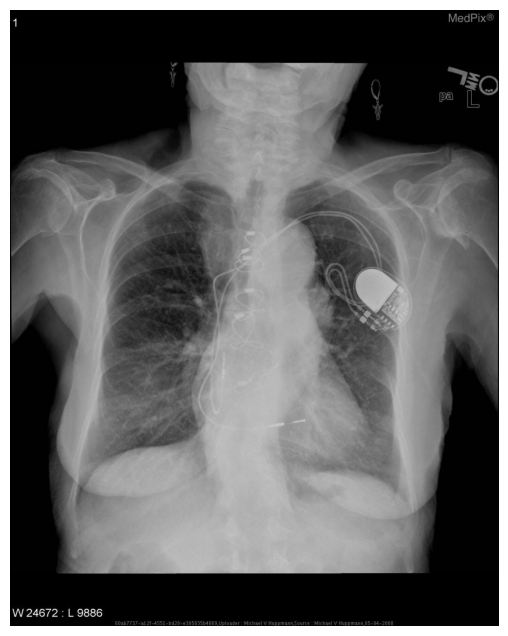


Sample 2:
Question: is there airspace consolidation on the left side?
True answer: yes
Predicted answer: no


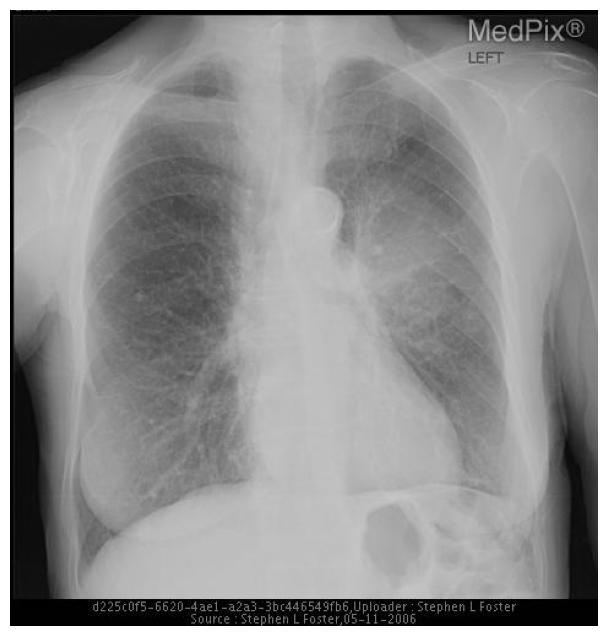


Sample 3:
Question: is there any intraparenchymal abnormalities in the lung fields?
True answer: no
Predicted answer: no


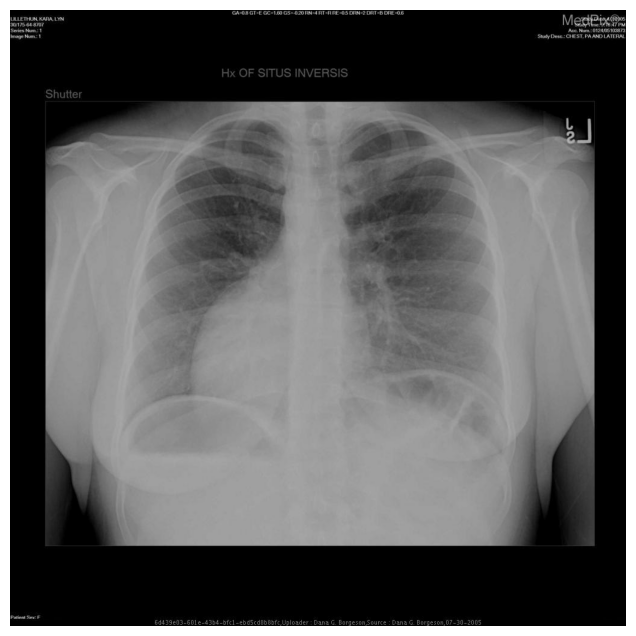


Sample 4:
Question: which side of the heart border is obscured?
True answer: right
Predicted answer: no


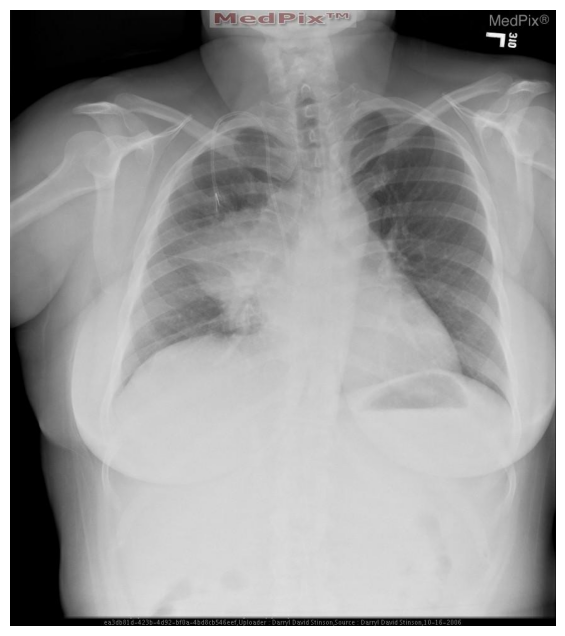


Sample 5:
Question: where are the kidney?
True answer: not seen here
Predicted answer: no


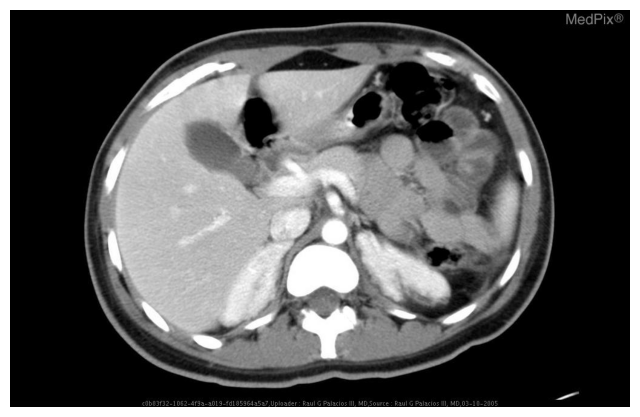

'\n# Test with your own image and question\nimage_path = "path/to/your/image.jpg"\nquestion = "What abnormality is seen in this image?"\nprocess_custom_input(\n    image_path, \n    question, \n    model, \n    question_vocab, \n    answer_vocab, \n    val_transform, \n    device\n)\n'

In [39]:
def predict_answer(model, image, question, question_vocab, answer_vocab, transform, device):
    """
    Make a prediction for a single image-question pair
    """
    # Set model to evaluation mode
    model.eval()
    
    # Prepare image
    if transform:
        image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    
    # Prepare question
    question = tokenize_text(question, question_vocab)
    question = question.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get prediction
    with torch.no_grad():
        outputs = model(image, question)
        _, predicted = outputs.max(1)
        answer_idx = predicted.item()
        
    # Convert prediction to answer text
    predicted_answer = answer_vocab.idx2word[answer_idx]
    
    return predicted_answer

# Load the best model
model.load_state_dict(torch.load('best_vqa_model.pth'))
model.eval()

# Example usage
def process_sample(sample_idx, dataset, model, question_vocab, answer_vocab, transform, device):
    # Get a sample from dataset
    sample = dataset.dataset[sample_idx]
    image = sample['image']
    question = sample['question']
    true_answer = sample['answer']
    
    # Make prediction
    pred_answer = predict_answer(
        model, 
        image, 
        question, 
        question_vocab, 
        answer_vocab,
        transform,
        device
    )
    
    # Print results
    print(f"Question: {question}")
    print(f"True answer: {true_answer}")
    print(f"Predicted answer: {pred_answer}")
    
    # Display image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Test on some samples from validation set
print("Testing model on validation samples...")
for i in range(5):  # Test 5 samples
    print(f"\nSample {i+1}:")
    process_sample(i, val_dataset, model, question_vocab, answer_vocab, val_transform, device)

# Function to process custom input
def process_custom_input(image_path, question, model, question_vocab, answer_vocab, transform, device):
    """
    Process a custom image and question
    """
    # Load and prepare image
    image = Image.open(image_path).convert('RGB')
    
    # Get prediction
    pred_answer = predict_answer(
        model, 
        image, 
        question, 
        question_vocab, 
        answer_vocab,
        transform,
        device
    )
    
    # Display results
    print(f"Question: {question}")
    print(f"Predicted answer: {pred_answer}")
    
    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage with custom input
"""
# Test with your own image and question
image_path = "path/to/your/image.jpg"
question = "What abnormality is seen in this image?"
process_custom_input(
    image_path, 
    question, 
    model, 
    question_vocab, 
    answer_vocab, 
    val_transform, 
    device
)
"""